<a href="https://colab.research.google.com/github/leomaranhao/COVID-19/blob/master/COVID_Brasil_Relatorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 NO BRASIL**

In [57]:
import pandas as pd
import numpy as np
import pandas.io.formats.format as pf
import datetime
import requests
import io

siglas_sudeste = ['RJ', 'SP', 'ES', 'MG']
siglas_sul = ['SC', 'RS', 'PR']
siglas_centro_oeste = ['MT', 'MS', 'DF', 'GO']
siglas_nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
siglas_norte = ['AC', 'AM', 'PA', 'RR', 'RO', 'AP', 'TO']


In [58]:
response = requests.get('https://brasil.io/dataset/covid19/caso?format=csv')
file_object = io.StringIO(response.content.decode('utf-8'))
df = pd.read_csv(file_object)


## **TOTAL DE CASOS**

In [59]:
estados = df.loc[df.place_type=='state',['date','state','confirmed','deaths','is_last', 'estimated_population_2019']]

ultimas = estados.loc[estados.is_last==True, :]

dataAtual = ultimas.iloc[0,0]
ultimas = ultimas.iloc[:, [2,3,5]]

ultimas.index.names = ['Estados']
ultimas.columns = ['Casos', 'Mortes', 'População 2019']

totalizacao = ultimas.loc[: , ['Casos', 'Mortes', 'População 2019'] ].sum()
totalizacao['Mortalidade(%)'] = totalizacao['Mortes']/totalizacao['Casos'] * 100
totalizacao['Casos/100 mil habitantes'] = totalizacao['Casos'] / totalizacao['População 2019'] * 100000

totalizacao = pd.DataFrame(totalizacao).T
totalizacao.index = [dataAtual]

styles = [
    dict(selector="table", props=[("border-collapse", "collapse")]),
    dict(selector="th", props=[("text-align", "center"),
                               ("width", "15%")]),
    dict(selector="td", props=[("border", "1px solid black"),
                               #("width", "10%"),
                               ("text-align", "right")])
]

html = (totalizacao.style.set_table_styles(styles)
          .format({'Casos' : '{0:,.0f}'})
          .format({'Mortes' : '{0:,.0f}'})
          .format({'População 2019' : '{0:,.0f}'})
          .format({'Mortalidade(%)' : '{0:,.2f}%'})
          .format({'Casos/100 mil habitantes' : '{0:,.2f}'})
          .set_caption(f'COVID-19 Brasil - {datetime.datetime.strptime(dataAtual, "%Y-%m-%d").strftime("%d/%m/%Y")}'))

html

,Casos,Mortes,População 2019,Mortalidade(%),Casos/100 mil habitantes
2020-06-20,"1,071,060","50,084","210,147,125",4.68%,509.67


In [60]:
estados = df.loc[df.place_type=='state',['date','state','confirmed','deaths','is_last', 'estimated_population_2019']]
estados.index = estados.state
estados.loc[siglas_sudeste, 'state'] = 'Sudeste'
estados.loc[siglas_sul, 'state'] = 'Sul'
estados.loc[siglas_nordeste, 'state'] = 'Nordeste'
estados.loc[siglas_norte, 'state'] = 'Norte'
estados.loc[siglas_centro_oeste, 'state'] = 'Centro Oeste'
estados.reset_index(drop=True, inplace=True)


In [61]:
tabela = pd.pivot_table(estados, values='deaths', index=['state'], columns=['date'], aggfunc=np.sum, fill_value=0)

tabela = tabela.T

tabela.columns.name = 'Região'

saida_intermediaria = tabela.copy()

saida = tabela.copy()

for j in range(0, tabela.shape[1]):
    for i in range(6, tabela.shape[0]):
        saida_intermediaria.iloc[i, j] = (tabela.iloc[i, j] + tabela.iloc[i-1, j] + tabela.iloc[i-2, j] + 
                                          tabela.iloc[i-3, j] + tabela.iloc[i-4, j] + tabela.iloc[i-5, j] +
                                          tabela.iloc[i-6, j]) / 7.0

for j in range(0, saida_intermediaria.shape[1]):
    for i in range(1, saida_intermediaria.shape[0]):
        saida.iloc[i, j] = saida_intermediaria.iloc[i, j] - saida_intermediaria.iloc[i-1, j]
        if (saida.iloc[i, j] < 0):
          saida.iloc[i, j]=0

for j in range(0, saida.shape[1]):
    for i in range(0, saida.shape[0]):
        if (saida.iloc[i, j] == 0):
            saida.iloc[i, j] = np.NaN
           
saida = saida.iloc[0:saida.shape[0]-1]            

for j in range(0, tabela.shape[1]):
    for i in range(0, tabela.shape[0]):
        if (tabela.iloc[i, j] == 0):
            tabela.iloc[i, j] = np.NaN

data_variacao = saida.index.values[len(saida.index)-1]
data_acumulado = tabela.index.values[len(tabela.index)-1]


## **EVOLUÇÃO POR REGIÃO**

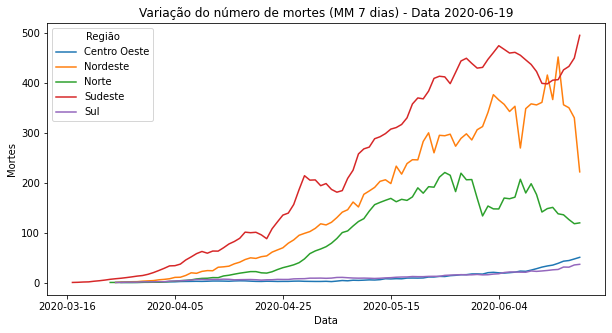

In [62]:
ax = saida.plot(figsize=(10,5), title = f"Variação do número de mortes (MM 7 dias) - Data {data_variacao}")
ax.set_xlabel("Data")
ax.set_ylabel("Mortes")
ax

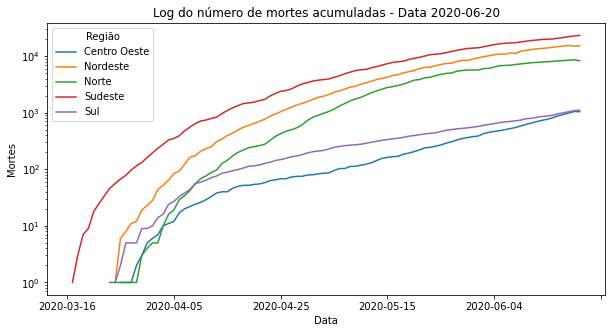

In [63]:
ax = tabela.plot(logy=True, figsize=(10,5), title = f"Log do número de mortes acumuladas - Data {data_acumulado}")
ax.set_xlabel("Data")
ax.set_ylabel(f"Mortes")
ax

In [64]:
tabela = pd.pivot_table(estados, values='confirmed', index=['state'], columns=['date'], aggfunc=np.sum, fill_value=0)

tabela = tabela.T

tabela.columns.name = 'Região'

saida_intermediaria = tabela.copy()

saida = tabela.copy()

for j in range(0, tabela.shape[1]):
    for i in range(6, tabela.shape[0]):
        saida_intermediaria.iloc[i, j] = (tabela.iloc[i, j] + tabela.iloc[i-1, j] + tabela.iloc[i-2, j] + 
                                          tabela.iloc[i-3, j] + tabela.iloc[i-4, j] + tabela.iloc[i-5, j] +
                                          tabela.iloc[i-6, j]) / 7.0

for j in range(0, saida_intermediaria.shape[1]):
    for i in range(1, saida_intermediaria.shape[0]):
        saida.iloc[i, j] = saida_intermediaria.iloc[i, j] - saida_intermediaria.iloc[i-1, j]
        if (saida.iloc[i, j] < 0):
          saida.iloc[i, j]=0

for j in range(0, saida.shape[1]):
    for i in range(0, saida.shape[0]):
        if (saida.iloc[i, j] == 0):
            saida.iloc[i, j] = np.NaN
           
saida = saida.iloc[0:saida.shape[0]-1]            

for j in range(0, tabela.shape[1]):
    for i in range(0, tabela.shape[0]):
        if (tabela.iloc[i, j] == 0):
            tabela.iloc[i, j] = np.NaN

data_variacao = saida.index.values[len(saida.index)-1]
data_acumulado = tabela.index.values[len(tabela.index)-1]


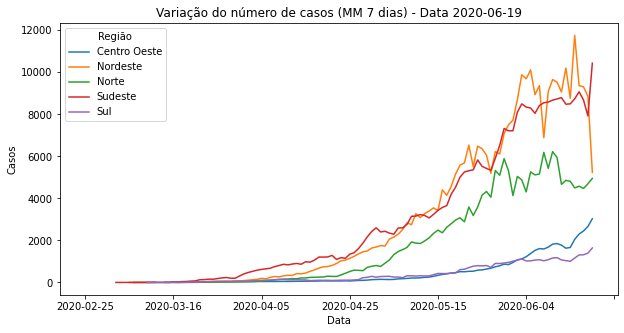

In [65]:
ax = saida.plot(figsize=(10,5), title = f"Variação do número de casos (MM 7 dias) - Data {data_variacao}")
ax.set_xlabel("Data")
ax.set_ylabel("Casos")
ax

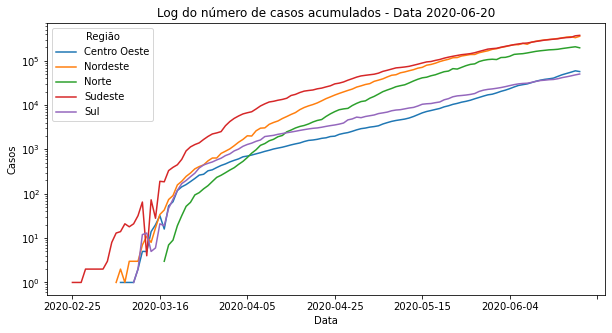

In [66]:
ax = tabela.plot(logy=True, figsize=(10,5), title = f"Log do número de casos acumulados - Data {data_acumulado}")
ax.set_xlabel("Data")
ax.set_ylabel(f"Casos")
ax

## **SITUAÇÃO NOS ESTADOS**

In [67]:
estados = df.loc[df.place_type=='state',['date','state','confirmed','deaths','is_last', 'estimated_population_2019']]

ultimas = estados.loc[estados.is_last==True, :]

ultimas.sort_values(by=['state'], inplace=True, ascending=False)

ultimas.index = ultimas['state']

dataAtual = ultimas.iloc[0,0]

ultimas = ultimas.iloc[:, [2,3,5]]

ultimas.index.names = ['Estados']
ultimas.columns = ['Casos', 'Mortes', 'População 2019']

ultimas['Mortalidade'] = ultimas['Mortes']/ultimas['Casos'] * 100
ultimas['Casos/100 mil habitantes'] = ultimas['Casos'] / ultimas['População 2019'] * 100000

styles = [
    dict(selector="table", props=[("border-collapse", "collapse")]),
    dict(selector="th", props=[("text-align", "center"),
                               ("width", "15%")]),
    dict(selector="td", props=[("border", "1px solid black"),
                               #("width", "10%"),
                               ("text-align", "right")])
]

html = (ultimas.style.set_table_styles(styles)
          .format({'Casos' : '{0:,.0f}'})
          .format({'Mortes' : '{0:,.0f}'})
          .format({'População 2019' : '{0:,.0f}'})
          .format({'Mortalidade' : '{0:,.2f}%'})
          .format({'Casos/100 mil habitantes' : '{0:,.2f}'})
          .highlight_max(color='lightgreen', subset=['Mortes', 'População 2019'])
          .highlight_min(color='#cd4f39', subset=['Mortes', 'População 2019'])
          .background_gradient(subset=['Casos'], cmap='PuRd')
          .background_gradient(subset=['Mortes'], cmap='Reds')
          .bar(color='#FFA07A', subset=['Mortalidade'], align='left')
          .bar(color='lightgreen', subset=['Casos/100 mil habitantes'], align='left')
          .set_caption(f'COVID-19 por Estados - {datetime.datetime.strptime(dataAtual, "%Y-%m-%d").strftime("%d/%m/%Y")}'))
html

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Casos,Mortes,População 2019,Mortalidade,Casos/100 mil habitantes
Estados,,,,,
TO,"8,203",167,"1,572,866",2.04%,521.53
SP,"215,793","12,494","45,919,049",5.79%,469.94
SE,"18,449",448,"2,298,696",2.43%,802.59
SC,"17,108",237,"7,164,788",1.39%,238.78
RS,"19,138",430,"11,377,239",2.25%,168.21
RR,"8,037",245,"605,761",3.05%,"1,326.76"
RO,"14,952",409,"1,777,225",2.74%,841.31
RN,"19,206",697,"3,506,853",3.63%,547.67
RJ,"95,537","8,824","17,264,943",9.24%,553.36


## **EVOLUÇÃO NOS ESTADOS MAIS ATINGIDOS**

In [68]:
ultimas['Estados'] = ultimas.index

ultimas.reset_index(drop=True, inplace=True)

ultimas.sort_values(by=['Mortes'], inplace=True, ascending=False)

siglas_estados = ultimas['Estados'][0:6].values.tolist()

estados = df.loc[df.place_type=='state',['date','state','confirmed','deaths','is_last', 'estimated_population_2019']]

tabela = pd.pivot_table(estados, values='deaths', index=['state'], columns=['date'], aggfunc=np.max, fill_value=0)

tabela = tabela.loc[siglas_estados].T

tabela.columns.name = 'Estado'

saida_intermediaria = tabela.copy()

saida = tabela.copy()

for j in range(0, tabela.shape[1]):
    for i in range(6, tabela.shape[0]):
        saida_intermediaria.iloc[i, j] = (tabela.iloc[i, j] + tabela.iloc[i-1, j] + tabela.iloc[i-2, j] + 
                                          tabela.iloc[i-3, j] + tabela.iloc[i-4, j] + tabela.iloc[i-5, j] +
                                          tabela.iloc[i-6, j]) / 7.0

for j in range(0, saida_intermediaria.shape[1]):
    for i in range(1, saida_intermediaria.shape[0]):
        saida.iloc[i, j] = saida_intermediaria.iloc[i, j] - saida_intermediaria.iloc[i-1, j]
        if (saida.iloc[i, j] < 0):
          saida.iloc[i, j]=0

for j in range(0, saida.shape[1]):
    for i in range(0, saida.shape[0]):
        if (saida.iloc[i, j] == 0):
            saida.iloc[i, j] = np.NaN
           
saida = saida.iloc[0:saida.shape[0]-1]            

for j in range(0, tabela.shape[1]):
    for i in range(0, tabela.shape[0]):
        if (tabela.iloc[i, j] == 0):
            tabela.iloc[i, j] = np.NaN

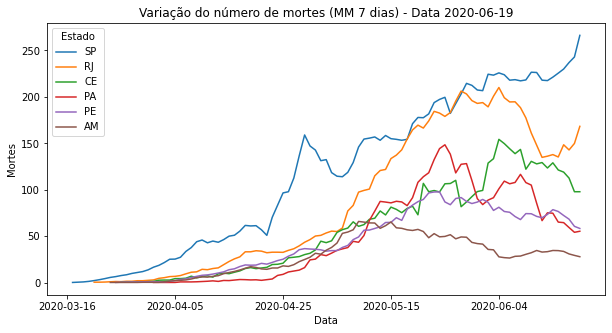

In [69]:
ax = saida.plot(figsize=(10,5), title = f"Variação do número de mortes (MM 7 dias) - Data {data_variacao}")
ax.set_xlabel("Data")
ax.set_ylabel("Mortes")
ax

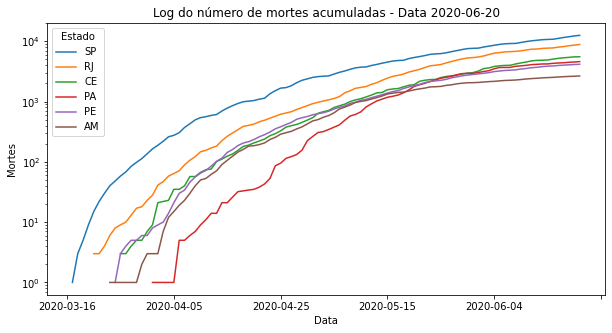

In [70]:
ax = tabela.plot(logy=True, figsize=(10,5), title = f"Log do número de mortes acumuladas - Data {data_acumulado}")
ax.set_xlabel("Data")
ax.set_ylabel("Mortes")
ax

In [71]:
tabela = pd.pivot_table(estados, values='confirmed', index=['state'], columns=['date'], aggfunc=np.max, fill_value=0)

tabela = tabela.loc[siglas_estados].T

tabela.columns.name = 'Estado'

saida_intermediaria = tabela.copy()

saida = tabela.copy()

for j in range(0, tabela.shape[1]):
    for i in range(6, tabela.shape[0]):
        saida_intermediaria.iloc[i, j] = (tabela.iloc[i, j] + tabela.iloc[i-1, j] + tabela.iloc[i-2, j] + 
                                          tabela.iloc[i-3, j] + tabela.iloc[i-4, j] + tabela.iloc[i-5, j] +
                                          tabela.iloc[i-6, j]) / 7.0

for j in range(0, saida_intermediaria.shape[1]):
    for i in range(1, saida_intermediaria.shape[0]):
        saida.iloc[i, j] = saida_intermediaria.iloc[i, j] - saida_intermediaria.iloc[i-1, j]
        if (saida.iloc[i, j] < 0):
                  saida.iloc[i, j]=0

for j in range(0, saida.shape[1]):
    for i in range(0, saida.shape[0]):
        if (saida.iloc[i, j] == 0):
            saida.iloc[i, j] = np.NaN
           
saida = saida.iloc[0:saida.shape[0]-1]            

for j in range(0, tabela.shape[1]):
    for i in range(0, tabela.shape[0]):
        if (tabela.iloc[i, j] == 0):
            tabela.iloc[i, j] = np.NaN

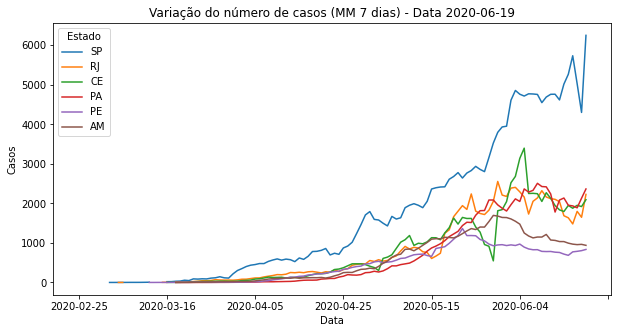

In [72]:
ax = saida.plot(figsize=(10,5), title = f"Variação do número de casos (MM 7 dias) - Data {data_variacao}")
ax.set_xlabel("Data")
ax.set_ylabel("Casos")
ax

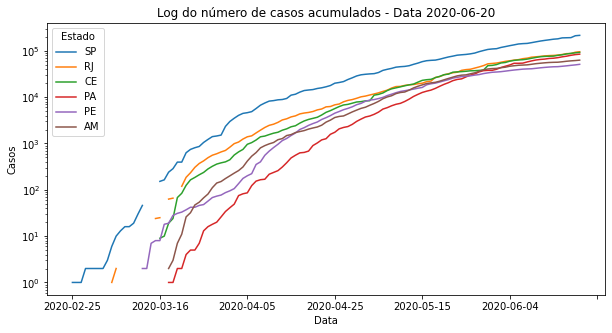

In [73]:
ax = tabela.plot(logy=True, figsize=(10,5), title = f"Log do número de casos acumulados - Data {data_acumulado}")
ax.set_xlabel("Data")
ax.set_ylabel("Casos")
ax